In [16]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sc
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

def dataset(dataFile, labelFile):
    dataFile = "./communication/" + dataFile
    labelFile = "./communication/" + labelFile
    my_data = sc.loadmat(dataFile)
    my_labels = sc.loadmat(labelFile)
    my_data = my_data['Y']
    X = my_labels['L_S_x']
    myOrig = table_data(my_data, my_labels['L_Constellations'][0], X)
    myTable = assign_labels(myOrig)
    return myTable

def table_data(my_data, cons, label):
    block = my_data.shape[1]
    my_data_size = my_data.shape[0] * block
    my_data_div = my_data.T.reshape(my_data_size,)
    cons_array = np.array([[cons[i]]*my_data.shape[0] for i in range(0,block)]).reshape(my_data_size,)
    block_array = np.array([([i+1]*my_data.shape[0])for i in range(0, block)]).reshape(my_data_size,)
    label_array = label.T.reshape(my_data_size,)
    test_pd = pd.DataFrame({'real':my_data_div.real,'imag':my_data_div.imag,
            'cons':cons_array, 'block':block_array,
            'label':label_array})
    return test_pd

def assign_labels(myTable):
    myTest = myTable.copy()
    myTest.loc[myTest.cons==2, 'label'] = myTest.loc[myTest.cons==2, 'label']+4
    myTest.label = myTest.label-1
    return myTest


from numpy.random import default_rng
def training_set(myTable):
    block = myTable.shape[0]
    rng = default_rng()
    sample_size = int(0.8 * block)
    numbers = rng.choice(range(1, block + 1), size=sample_size, replace=False)
    training_dataset = myTable[myTable.block.isin(numbers)]
    return training_dataset

def test_set(myTable, training_dataset):
    remaining = myTable.drop(training_dataset.index)
    return remaining



def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(50, activation='relu'),
        layers.Dense(50, activation='relu'),
        layers.Dense(20)
    ])
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(0.01),
                 metrics=['accuracy'])
    return model

def get_total_loss(predict_label, true_label):
    i = 0
    for j in range(len(predict_label)):
        prediction = np.argmax(predict_label[j])
        if prediction != true_label[j]:
            i = i + 1
    return i/len(predict_label)

datas = "INR30data"
labels = "INR30labels"


def get_training(myTable, epochs, files):
    train_dataset = training_set(myTable)
    test_dataset = test_set(myTable, train_dataset)
    train_features = train_dataset.copy()
    test_features = test_dataset.copy()
    train_labels = pd.DataFrame([train_features.pop('label')]).T
    test_labels = pd.DataFrame([test_features.pop('label')]).T
    normalizer = preprocessing.Normalization()
    normalizer.adapt(np.array(train_features))
    dnn_real_model = build_and_compile_model(normalizer)
    history = dnn_real_model.fit(
        train_features, train_labels,
        validation_split=0.2,
        epochs=epochs)
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    test_results = {}
    test_results['signal'] = dnn_real_model.evaluate(
        test_features,
        test_labels, verbose=0)
    probability_model = tf.keras.Sequential([dnn_real_model,
                                             tf.keras.layers.Softmax()])
    predictions = probability_model.predict(test_features)
    '''
    plt.clf()
    plot_loss(history)
    plt.savefig('./results/'+files, dpi=300, bbox_inches='tight')
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    hist.tail()
    hist = hist.append(test_results, ignore_index=True)
    hist.to_csv('./results/' + files + '.csv', index=False)
    '''
    return [predictions, test_labels]



def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [Ireal]')
    plt.legend()
    plt.grid(True)


def prediction(model, testTable, test_results, fileNanme):
    test_features = testTable.copy()
    test_labels = pd.DataFrame([test_features.pop('label')]).T
    test_results[fileNanme] = model.evaluate(
        test_features,
        test_labels, verbose=0)

In [11]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [Ireal]')
    plt.legend()
    plt.grid(True)

In [12]:
myTable = dataset("INR30data", "INR30labels")

In [4]:
my_data = "my_data"
my_labels = "my_labels"
INR30data = "INR30data"
INR30labels = "INR30labels"
INR30with90data = "INR30with90data"
INR30with90labels = "INR30with90labels"
noise30data = "noise30data"
noise30label = "noise30label"

myTable = dataset(my_data, my_labels)
INR30Table = dataset(INR30data, INR30labels)
INR30with90Table = dataset(INR30with90data, INR30with90labels)
noise30Table = dataset(noise30data, noise30label)

test = [myTable, INR30Table, INR30with90Table, noise30Table]
name = [my_data, INR30data, INR30with90data, noise30data]
result = {}

In [17]:
my_data = "my_data"
my_labels = "my_labels"
myTable = dataset(my_data, my_labels)

In [54]:
results = get_training(INR30Table, 10, "normal")

Epoch 1/10
999/999 [==============================] - 1s 841us/step - loss: 0.9358 - accuracy: 0.6671 - val_loss: 0.7569 - val_accuracy: 0.6725
Epoch 2/10
999/999 [==============================] - 1s 725us/step - loss: 0.5868 - accuracy: 0.7439 - val_loss: 0.5109 - val_accuracy: 0.7509
Epoch 3/10
999/999 [==============================] - 1s 711us/step - loss: 0.4468 - accuracy: 0.7898 - val_loss: 0.3728 - val_accuracy: 0.8212
Epoch 4/10
999/999 [==============================] - 1s 727us/step - loss: 0.3851 - accuracy: 0.8137 - val_loss: 0.3814 - val_accuracy: 0.8134
Epoch 5/10
999/999 [==============================] - 1s 713us/step - loss: 0.3500 - accuracy: 0.8235 - val_loss: 0.4395 - val_accuracy: 0.7984
Epoch 6/10
999/999 [==============================] - 1s 749us/step - loss: 0.3354 - accuracy: 0.8314 - val_loss: 0.3168 - val_accuracy: 0.8335
Epoch 7/10
999/999 [==============================] - 1s 710us/step - loss: 0.3235 - accuracy: 0.8340 - val_loss: 0.3190 - val_accuracy:

In [63]:
predictions = []
for i in range(len(results[0])):
    predictions.append(np.argmax(results[0][i]))

In [64]:
test1 = tf.math.confusion_matrix(predictions, results[1].to_numpy()).numpy()

In [67]:
test2 = np.around(test1.astype('float') / test1.sum(axis=1)[:, np.newaxis], decimals=2)

In [68]:
test2

array([[1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.15, 0.64, 0.09, 0.12, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.13, 0.  , 0.87, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.04, 0.12, 0.84, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.96, 0.  , 0.  , 0.  , 0.  , 0.04, 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.93, 0.  , 0.  , 0.05, 0.  , 0.02,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.99, 0.  , 0.  , 0.  , 0.  ,
        0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0. 

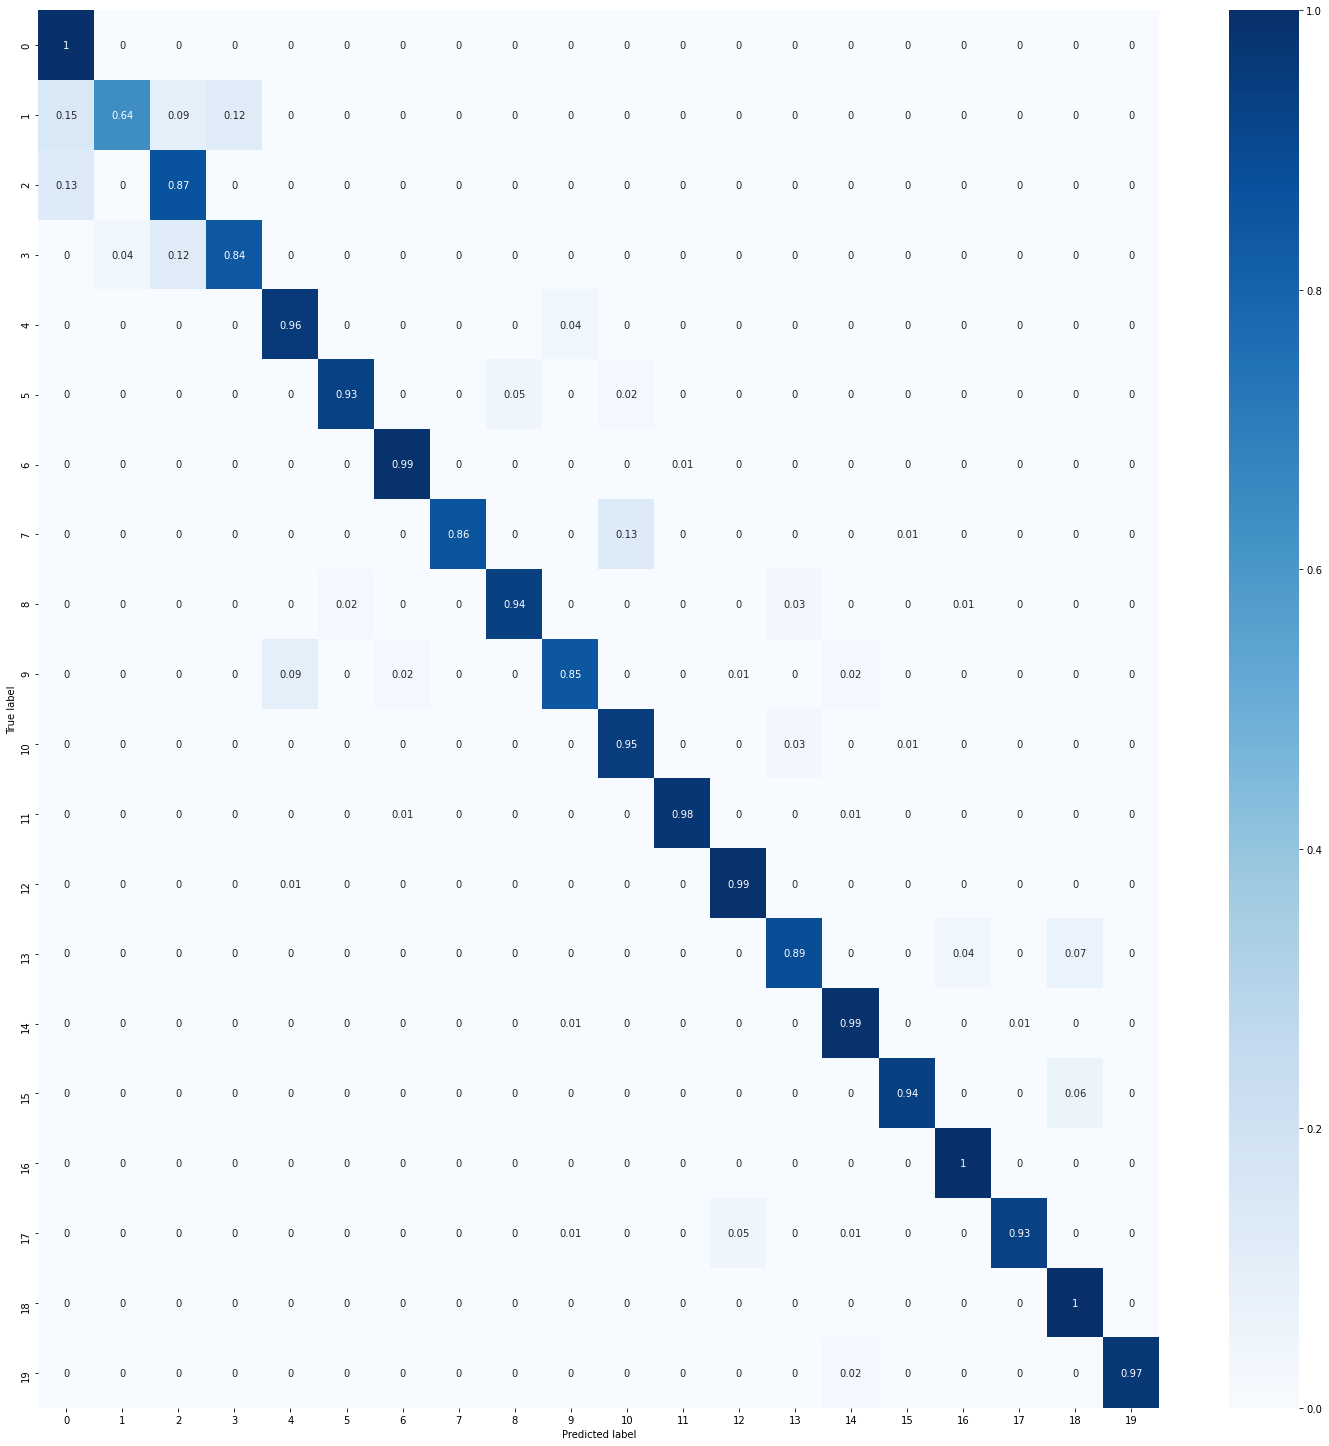

In [69]:
import seaborn as sns
figure = plt.figure(figsize=(20, 20))
sns.heatmap(test2, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig("./result3/INR30", dpi=1000)